In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

In [ ]:
# import data from github repo
df = pd.read_csv("https://raw.githubusercontent.com/ai4good-m3/tyro/master/modified%20data%20lily.csv", sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    14 non-null     object
 1   TSH     14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


Convert the entries to float

In [ ]:
df = df.replace(",", ".", regex=True)
df["TSH"] = df["TSH"].astype("float")
df["TSH"]=df["TSH"].dropna()

Get informations about the data with the help of adfuller

In [ ]:
# find p and d
result = adfuller(df["TSH"].dropna(), autolag = 'AIC')
print('ADF Statistic: %f' % result[0])
print('P-value: %f' % result[1])
print('Number of lags:', result[2])
print('Number of observations used for ADF regression:', result[3])
print('Critical values:')
for key, val in result[4].items():
  print('\t',key,':',val)

# this returns p=0.000002, which is under the significance level of 0.05
# therefore we don't need to differentiate, so we will try a first model with d=0

ADF Statistic: -2.128287
P-value: 0.233293
Number of lags: 5
Number of observations used for ADF regression: 8
Critical values:
	 1% : -4.6651863281249994
	 5% : -3.3671868750000002
	 10% : -2.802960625


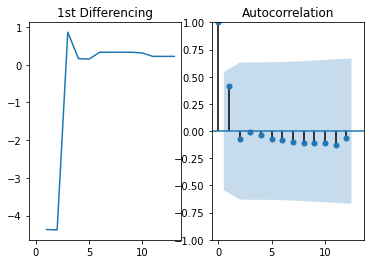

In [ ]:
# find q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df["TSH"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df["TSH"].diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
print(df["TSH"])

0     9.43
1     5.06
2     0.68
3     1.54
4     1.70
5     1.85
6     2.18
7     2.51
8     2.84
9     3.17
10    3.48
11    3.70
12    3.92
13    4.14
Name: TSH, dtype: float64


Compute the log of the dataset, so that when we convert it back to exp the values remain strictly positive (as hormone levels ought to be)

In [ ]:
from math import log, exp
log_TSH=[]
for i in range(len(df["TSH"])):
  cur = df["TSH"][i]
  log_TSH.append(log(cur))

In [ ]:
df["log_TSH"]=log_TSH

In [ ]:
# ARIMA implementation
from statsmodels.tsa.arima.model import ARIMA

# 0,0,1 ARIMA Model
model = ARIMA(df["log_TSH"].dropna(), order=(0,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                log_TSH   No. Observations:                   14
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -11.009
Date:                Thu, 16 Jun 2022   AIC                             28.018
Time:                        19:42:45   BIC                             29.935
Sample:                             0   HQIC                            27.841
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0504      0.229      4.582      0.000       0.601       1.500
ma.L1          0.5843      0.446      1.311      0.190      -0.289       1.458
sigma2         0.2739      0.108      2.533      0.0

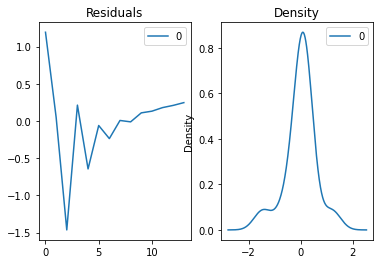

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

We have a near 0 mean and the variance is near uniform.
Now plot the actuals VS fitted values.

In [ ]:
y = model_fit.predict(dynamic=False)
print(y.to_numpy)

<bound method IndexOpsMixin.to_numpy of 0     1.037000
1     1.494742
2     1.021893
3     0.322706
4     1.211035
5     0.643955
6     1.085577
7     0.862984
8     1.096524
9     0.998615
10    1.127674
11    1.087177
12    1.149208
13    1.136770
Name: predicted_mean, dtype: float64>


Take the exponential of the predictions so that they go back to normal, strictly positive, levels


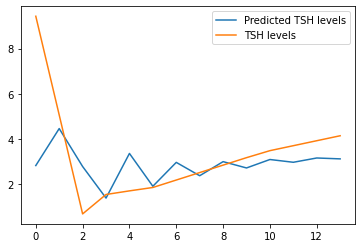

In [ ]:
preds = np.exp(y)
real = df["TSH"]
plt.plot(preds, label="Predicted TSH levels")
plt.plot(real, label="TSH levels")
plt.legend()
plt.show()

Let's try **auto-ARIMA**

In [ ]:
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

model = pm.auto_arima(df["log_TSH"].dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True, stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=36.316, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=32.150, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=34.360, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=33.396, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=30.868, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=32.197, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=32.221, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=30.294, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=32.206, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=34.198, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.961 seconds
                               SARIMAX Results           

NEXT STEP: do out-of-time cross-validation: split the time series into a 75:25 ratio (training:testing). For now, there is too little data.

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df["TSH"][:11]
# The test set will consist of the 6th datapoint
test = df["TSH"][10:]

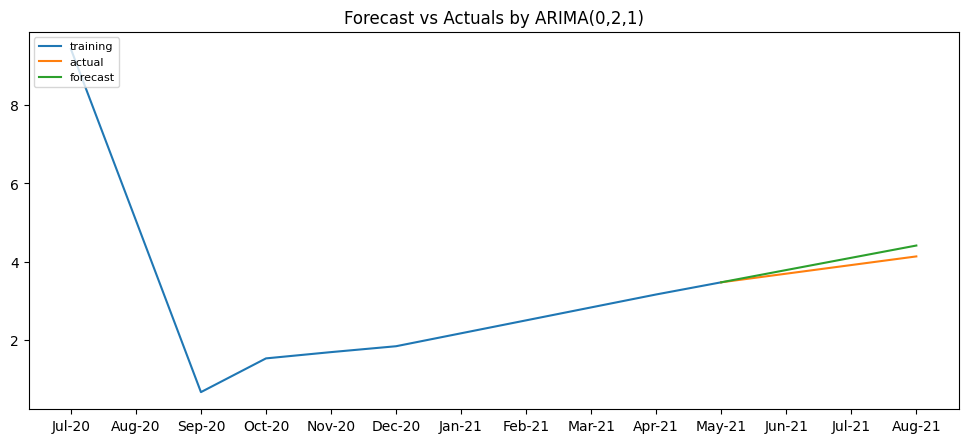

In [ ]:
# Build Model with parameters (0,2,1), as recommended by auto-arima
model = ARIMA(train, order=(0,2,1))
fitted = model.fit()

# Forecast
fc = fitted.forecast(3, alpha=0.05)  # 95% conf

# Make as pandas series

fc_series=pd.Series(fc)
ten=pd.Series(df["TSH"][10], index=[10])
fc_series = pd.concat([ten, fc_series])

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
dates=df["Date"].to_numpy()
d=np.arange(14)
plt.xticks(d,dates)
plt.title('Forecast vs Actuals by ARIMA(0,2,1)')
plt.legend(loc='upper left', fontsize=8)
plt.show()